In [1]:
# Import necessary package here.
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq, ifft 
from matplotlib.colors import LogNorm
from helper import open_dat_file

import struct

# Configure plot universal property
plt.rcParams['figure.figsize'] = (12,10)
plt.rcParams['font.size'] = 16

%matplotlib inline

data_dir = './Data/Data_ex2'

A radar image represents two-dimensional data. This requires not only focusing in range (see first exercise) but also focusing in azimuth (= along track, i.e. in the flight direction of the sensor). You will find the formulas required for the range and azimuth chirp rates in the tutorial on epsilon nought (http://epsilon.nought.de/).

# 2.1 2D Chirp (point source)
Use the information in the file [chirp 2d test constants.txt] and [chirp 2d test.dat] to focus (or compress) the 2-D radar raw data. The image represent the raw-format of radar data of a single strong scatterer. After focusing in range an azimuth, the image still consists of complex values. This data format is called single-look-complex or SLC. Most radar data is distributed in the SLC format.

*Definition of the .DAT format: * 

two LONG values representing the number of pixels in range and azimuth direction. Then follows a sequence of complex values which represent a 2D matrix of the dimension given by range and azimuth. Write a binary-reader function to import the data. When you visualize the data, you should see several rings. (IDL functions that may help: openr, readu, close, free lun, lonarr, complexarr, shade surf)

### Tasks: 

1. compress the 2D raw data: 
    Plot intensity and phase of the compressed image.
2. compress the 2D raw data using an Hamming filter in azimuth: 
    Visualize the intensity and phase of the compressed image.
3. compress the 2D raw data using two looks in the azimuth spectrum: 
    Split the azimuth-spectrum and focus both spectra independently. Then average the magnitude of both images. 
    
**Literature: Chapter 2.2 in the ”Scientific SAR User’s Guide” by Coert Olmsted.**

In [3]:
test_img = open_dat_file(data_dir+'/chirp_2d_test.dat')
N_azi, N_rg = test_img.shape

Opening file: ./Data/Data_ex2/chirp_2d_test.dat
 - Range:   512
 - Azimuth: 1081


In [4]:
#Define Constants
R0 = 1000 #closest range, (m)
v = 70    #sensor velocity (m/s)
L_antenna = 2  #antenna length (m)

lamda = 0.0566 #wavelength
C = 3e8    #speed of light (m/s)
Bw = 50e6  #bandwidth (Hz)
Tau = 5e-6 #pulse width (s)
Fs_range = 100e6  #sampling frequency in range (Hz)
PRF = 400  #pulse repetition frequency (Hz)

omega = 2 * np.pi * Fs_range
t = np.arange(-Tau/2, Tau/2, 1/Fs_range)
beta = Bw / Tau
N = t.shape[0]

In [17]:
h = np.conj(np.flip(np.exp(-1j * np.pi*Bw/Tau*t**2)))

pad_len = round((N_rg-N)/2)
h = np.pad(h, (pad_len, pad_len), 'constant', constant_values=(0, 0))
h = np.roll(h, round(N_rg/2))

h_fft = fft(h, n=N_rg)*N_rg
rg_focus = ifft(fft(test_img, axis=1) * h_fft)

alpha = 0.54
hw = alpha + (1-alpha)*np.cos(2*np.pi*t/Tau)
hw = np.pad(hw, (pad_len, pad_len), 'constant', constant_values=0)
hw = np.roll(hw, round(N_rg/2))

hh_fft = fft(hw * h, n=N_rg) * N_rg
rg_focus_hm = ifft(fft(test_img, axis=1) * hh_fft)

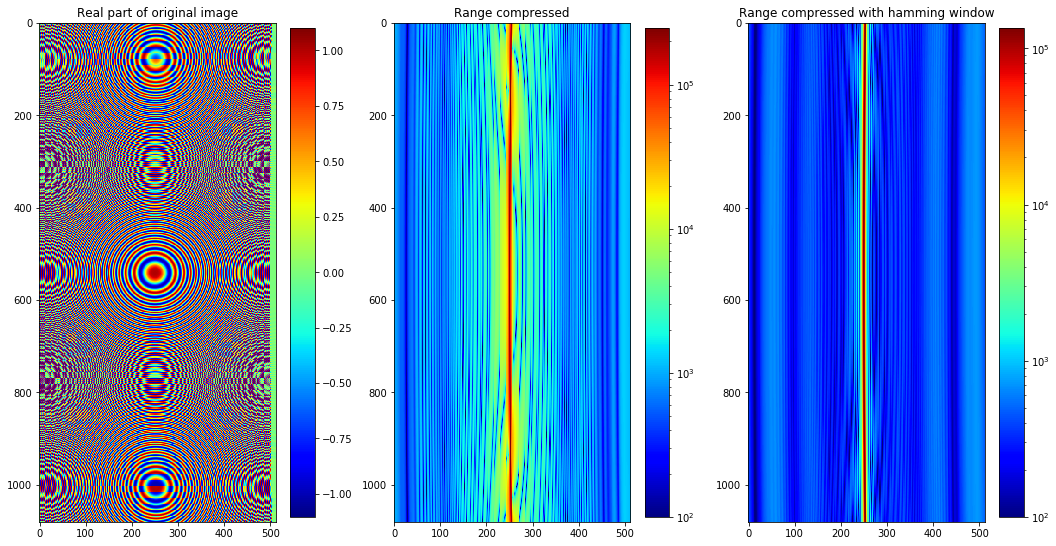

In [18]:
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(131)
real_part = ax1.imshow(np.real(test_img), cmap='jet')
fig.colorbar(real_part, ax=ax1, shrink=0.9)
ax1.set_title('Real part of original image')
# cbar1 = fig.colorbar(real_part)

# ax2 = fig.add_subplot(132)
# imag_part = ax2.imshow(np.imag(test_img), cmap='jet')
# fig.colorbar(imag_part, ax=ax2, shrink=0.9)

ax2 = fig.add_subplot(132)
# rg_img = ax2.imshow(np.abs(rg_focus), cmap='jet')
log_cmp = LogNorm(vmin=100, vmax=np.max(np.abs(rg_focus)))
rg_img = ax2.imshow(np.abs(rg_focus), cmap='jet', norm=log_cmp)
fig.colorbar(rg_img, ax=ax2, shrink=0.9)
ax2.set_title('Range compressed')
ax3 = fig.add_subplot(133)
log_cmp = LogNorm(vmin=100, vmax=np.max(np.abs(rg_focus_hm)))
rghm_img = ax3.imshow(np.abs(rg_focus_hm), cmap='jet', norm=log_cmp)
fig.colorbar(rghm_img, ax=ax3, shrink=0.9)
ax3.set_title('Range compressed with hamming window')
# cbar.set_clim(-0.4e8, 0.8e8)

plt.show()

In [69]:
l_syn = lamda * R0 / L_antenna
k_azi = 2 * np.pi * v**2 / (lamda*R0)
t_max = l_syn / v
t_azi = np.arange(-t_max/2, t_max/2, 1/PRF)

h_azi = np.conj(np.flip(np.exp(-1j * k_azi*t_azi**2)))
pad_len = round((N_azi-t_azi.shape[0])/2)
h_azi = np.pad(h_azi, (pad_len, pad_len), 'constant', constant_values=(0, 0))
h_azi = np.roll(h_azi, round(N_azi/2))

h_azi_fft = fft(h_azi, n=N_azi) * N_azi

azi_focus = np.zeros_like(rg_focus, dtype=np.complex_)
for i in range(N_rg):
    azi_focus[:, i] = ifft(fft(rg_focus[:, i]) * h_azi_fft)
    
hw_az = alpha + (1-alpha)*np.cos(2*np.pi*t_azi/t_max)
pad_len = round((N_azi-t_azi.shape[0])/2)
hw_az = np.pad(hw_az, (pad_len, pad_len), 'constant', constant_values=(0, 0))
hw_az = np.roll(hw_az, round(N_azi/2))

hh_azi_fft = fft(hw_az * h_azi, n=N_azi) * N_azi
azi_hamming = np.zeros_like(rg_focus, dtype=np.complex_)
for i in range(N_rg):
    azi_hamming[:, i] = ifft(fft(rg_focus[:, i]) * hh_azi_fft)

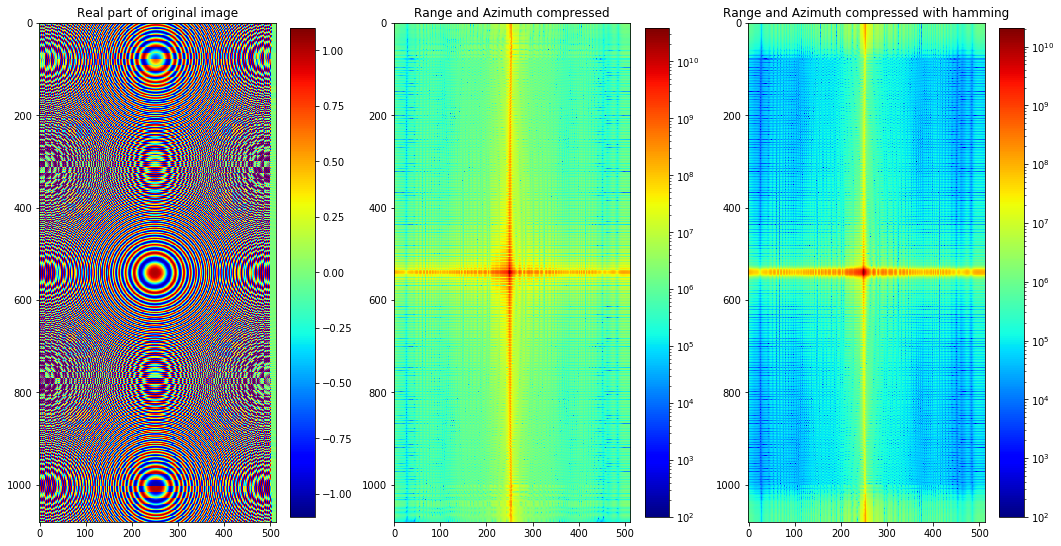

In [71]:
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(131)
real_part = ax1.imshow(np.real(test_img), cmap='jet')
fig.colorbar(real_part, ax=ax1, shrink=0.9)
ax1.set_title('Real part of original image')

ax2 = fig.add_subplot(132)
log_cmp = LogNorm(vmin=100, vmax=np.max(np.abs(azi_focus)))
azi_img = ax2.imshow(np.abs(azi_focus), cmap='jet', norm=log_cmp)
cbar = fig.colorbar(azi_img, ax=ax2, shrink=0.9)
ax2.set_title('Range and Azimuth compressed')

ax3 = fig.add_subplot(133)
log_cmp = LogNorm(vmin=100, vmax=np.max(np.abs(azi_hamming)))
azi_img = ax3.imshow(np.abs(azi_hamming), cmap='jet', norm=log_cmp)
cbar = fig.colorbar(azi_img, ax=ax3, shrink=0.9)
ax3.set_title('Range and Azimuth compressed with hamming')

plt.show()